In [1]:
conda install -c glemaitre imbalanced-learn

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::holoviews==1.15.0=py39hecd8cb5_0
  - defaults/noarch::tifffile==2021.7.2=pyhd3eb1b0_2
  - defaults/osx-64::imageio==2.19.3=py39hecd8cb5_0
  - defaults/noarch::arrow==1.2.2=pyhd3eb1b0_0
  - defaults/noarch::requests-file==1.5.1=pyhd3eb1b0_0
  - defaults/osx-64::botocore==1.27.28=py39hecd8cb5_0
  - defaults/osx-64::bottleneck==1.3.5=py39h67323c0_0
  - defaults/osx-64::astroid==2.11.7=py39hecd8cb5_0
  - defaults/noarch::nbclassic==0.3.5=pyhd3eb1b0_0
  - defaults/noarch::cookiecutter==1.7.3=pyhd3eb1b0_0
  - defaults/osx-64::scikit-image==0.19.2=py39hae1ba45_0
  - defaults/osx-64::anaconda-project==0.11.1=py39hecd8cb5_0
  - defaults/noarch::argon2-cffi==21.3.0=pyhd3eb1b0_0
  - defaults/osx-64::datashape==0.5.4=py39hecd8cb5_1
  - defaults/osx-64::boto3==1.24.28=py39hecd8cb5_0
  - defaults/osx-64::mkl_random==1.2.2=py39hb2

  Date received                  Product                   Sub-product  \
0    2016-10-26          Money transfers  International money transfer   
1    2015-03-27  Bank account or service    Other bank product/service   
2    2015-04-20  Bank account or service    Other bank product/service   
3    2013-04-29                 Mortgage   Conventional fixed mortgage   
4    2013-05-29                 Mortgage                Other mortgage   

                                      Issue Sub-issue  \
0                  Other transaction issues       NaN   
1   Account opening, closing, or management       NaN   
2  Making/receiving payments, sending money       NaN   
3  Application, originator, mortgage broker       NaN   
4  Loan modification,collection,foreclosure       NaN   

                        Consumer complaint narrative  \
0  To whom it concerns, I would like to file a fo...   
1  My name is XXXX XXXX XXXX and huband name is X...   
2  XXXX 2015 : I called to make a payment on

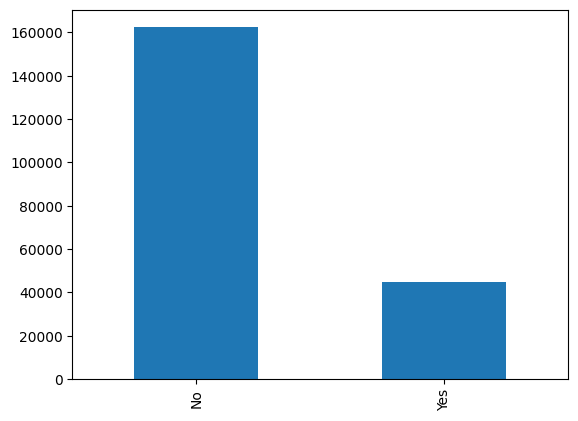

In [3]:
import pandas as pd

# Load the data
df = pd.read_csv('complaints_25Nov21.csv')

# Display the first few rows of the dataframe
print(df.head())

# Get a summary of the dataframe
print(df.info())

# Get summary statistics of the dataframe
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize the distribution of the 'Consumer disputed?' column
import matplotlib.pyplot as plt
df['Consumer disputed?'].value_counts().plot(kind='bar')
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# Fill missing values
df.fillna('missing', inplace=True)

# Set predictor and predicted variables
X = df[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]
y = df['Consumer disputed?']

# Convert categorical values to numerical
X = pd.get_dummies(X)

# Convert y-variable to 0s and 1s
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

# Split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

# Calculate the proportion of consumers who raised a dispute in the test set
dispute_proportion = y_test.sum() / len(y_test)

print(dispute_proportion)

0.21586413200810575


In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random undersampling
undersampler = RandomUnderSampler(random_state=123)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Calculate the proportion of consumers who raised a dispute in the resampled training set
dispute_proportion_resampled = y_train_resampled.sum() / len(y_train_resampled)

print(dispute_proportion_resampled)

0.5


In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Fit the XGBClassifier model
model_xgb = XGBClassifier(random_state = 123)
model_xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model_xgb.predict(X_test)

# Create the classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.84      0.53      0.65     32504
           1       0.27      0.63      0.38      8948

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.72      0.55      0.59     41452



In [7]:
# Calculate the number of disputed and not disputed complaints
num_disputed = y_test.sum()
num_not_disputed = len(y_test) - num_disputed

# Calculate the total cost
total_cost = num_not_disputed * 100 + num_disputed * 600

print(total_cost)


8619200


In [8]:
# Perform random undersampling if proportion of disputed complaints is less than 30%
if y_train.mean() < 0.3:
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_train, y_train)

# Fit the XGBClassifier model
model_xgb = XGBClassifier(random_state = 123)
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_xgb.predict(X_test)

# Create the classification report and confusion matrix
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

# Print the classification report and confusion matrix
print(report)
print(matrix)

              precision    recall  f1-score   support

           0       0.84      0.53      0.65     32504
           1       0.27      0.63      0.38      8948

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.72      0.55      0.59     41452

[[17128 15376]
 [ 3302  5646]]


In [9]:
# Calculate the total cost
tn, fp, fn, tp = matrix.ravel()
total_cost = tn*100 + fp*190 + fn*600 + tp*190
print(f'Total cost: ${total_cost}')

Total cost: $7688180


In [10]:
import numpy as np

# Get the predicted probabilities of the positive class
y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

# Initialize the minimum cost and optimal threshold
min_cost = np.inf
optimal_threshold = 0

# Iterate over a range of possible thresholds
for threshold in np.linspace(0, 1, 100):
    # Convert predicted probabilities to class labels based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate the confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate the total cost
    tn, fp, fn, tp = matrix.ravel()
    total_cost = tn*100 + fp*190 + fn*600 + tp*190
    
    # If the current cost is less than the minimum cost, update the minimum cost and optimal threshold
    if total_cost < min_cost:
        min_cost = total_cost
        optimal_threshold = threshold

# Print the optimal threshold and minimum cost
print(f'Optimal threshold: {optimal_threshold}')
print(f'Minimum cost: ${min_cost}')

Optimal threshold: 0.43434343434343436
Minimum cost: $7610470
